In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from scipy.stats import chi2_contingency, shapiro
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.diagnostic as dg
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.stattools import durbin_watson

# Data Reading

In [67]:
data = pd.read_excel(r"Project data.xls")

In [68]:
data.head()

,business_registered,TIN,business_license,subsector,MSE_type,loan,land_premise,one_stop_service,util_rate,current_capital,initial_capital,gender,years_establish,years_schooling,no_paid_workers,highest_education
0,1,0,1,1,1,1,0,1,5,3000,2000.0,0,0,10,3,4
1,1,1,1,1,1,1,1,1,25,100000,500.0,1,10,10,3,4
2,1,1,1,1,1,0,0,1,30,15000,12000.0,0,1,10,3,4
3,1,1,1,1,1,1,0,1,40,50000,4500.0,0,3,10,3,4
4,1,1,1,1,1,1,0,1,50,15000,6000.0,0,4,9,3,4


In [69]:
# correcting categorical data type
categorical_columns = data.columns[~ data.columns.isin(["util_rate", "current_capital", "initial_capital", "years_establish",
                    "years_schooling", "no_paid_workers"])]
for col in categorical_columns:
    data[col] = pd.Categorical(data[col])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860 entries, 0 to 859
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   business_registered  860 non-null    category
 1   TIN                  860 non-null    category
 2   business_license     860 non-null    category
 3   subsector            860 non-null    category
 4   MSE_type             860 non-null    category
 5   loan                 860 non-null    category
 6   land_premise         860 non-null    category
 7   one_stop_service     860 non-null    category
 8   util_rate            860 non-null    int64   
 9   current_capital      860 non-null    int64   
 10  initial_capital      860 non-null    float64 
 11  gender               860 non-null    category
 12  years_establish      860 non-null    int64   
 13  years_schooling      860 non-null    int64   
 14  no_paid_workers      860 non-null    int64   
 15  highest_education    86

# EDA

In [70]:
sns.set_theme(
    context="talk",
    style="ticks",
    palette="colorblind",
    font="sans-serif"
)

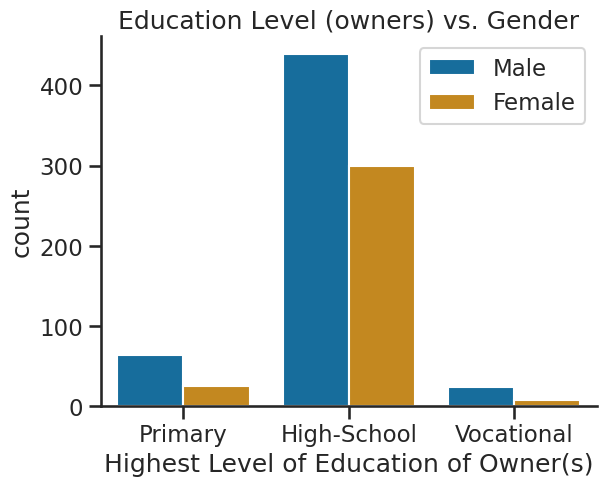

In [71]:
sns.countplot(
    data = data,
    x = "highest_education",
    hue = "gender"
)
plt.title("Education Level (owners) vs. Gender")
plt.xlabel("Highest Level of Education of Owner(s)")
plt.xticks(ticks =[0, 1, 2], labels=["Primary", "High-School", "Vocational"])
plt.legend(labels=["Male", "Female"])
sns.despine()
plt.show()

In [72]:
subsector_count = data["subsector"].value_counts().sort_index().reset_index()
subsector_count["label"] = subsector_count["subsector"].map({
    1 : "Metal and wood work",
    2 : "Construction",
    3 : "Agro-processing",
    4 : "Textile and garment",
    5 : "Leather and footwear",
    6 : "Retail",
    7 : "Urban agriculture",
    8 : "Others"
})
subsector_count

,subsector,count,label
0,1,122,Metal and wood work
1,2,64,Construction
2,3,183,Agro-processing
3,4,87,Textile and garment
4,5,34,Leather and footwear
5,6,273,Retail
6,7,42,Urban agriculture
7,8,55,Others


In [73]:
pie = px.pie(
    data_frame=subsector_count,
    names="label",
    values="count",
    title="Sub-Sectors of MSE",
    hole=0.4,
    template="plotly_white",
    color_discrete_sequence=px.colors.qualitative.Safe
)
pie.update_traces(textinfo='percent+label', hoverinfo='label+value+percent')
pie.update_layout(
    margin=dict(t=33, b=25, l=50, r=50)
)
pie

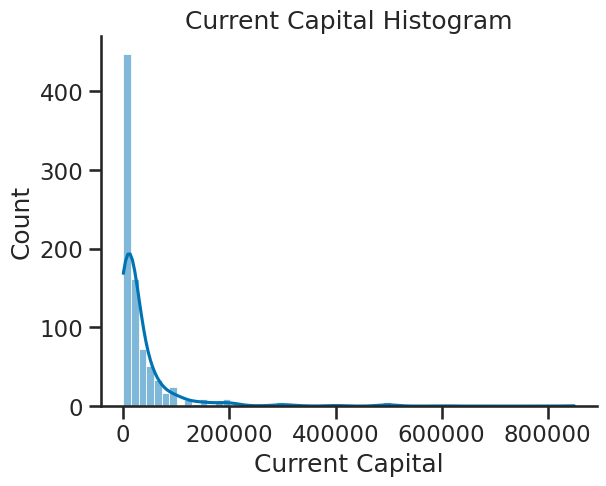

In [74]:
sns.histplot(
    data = data,
    x = "current_capital",
    kde = True
)
plt.title("Current Capital Histogram")
plt.xlabel("Current Capital")
sns.despine()
plt.show()

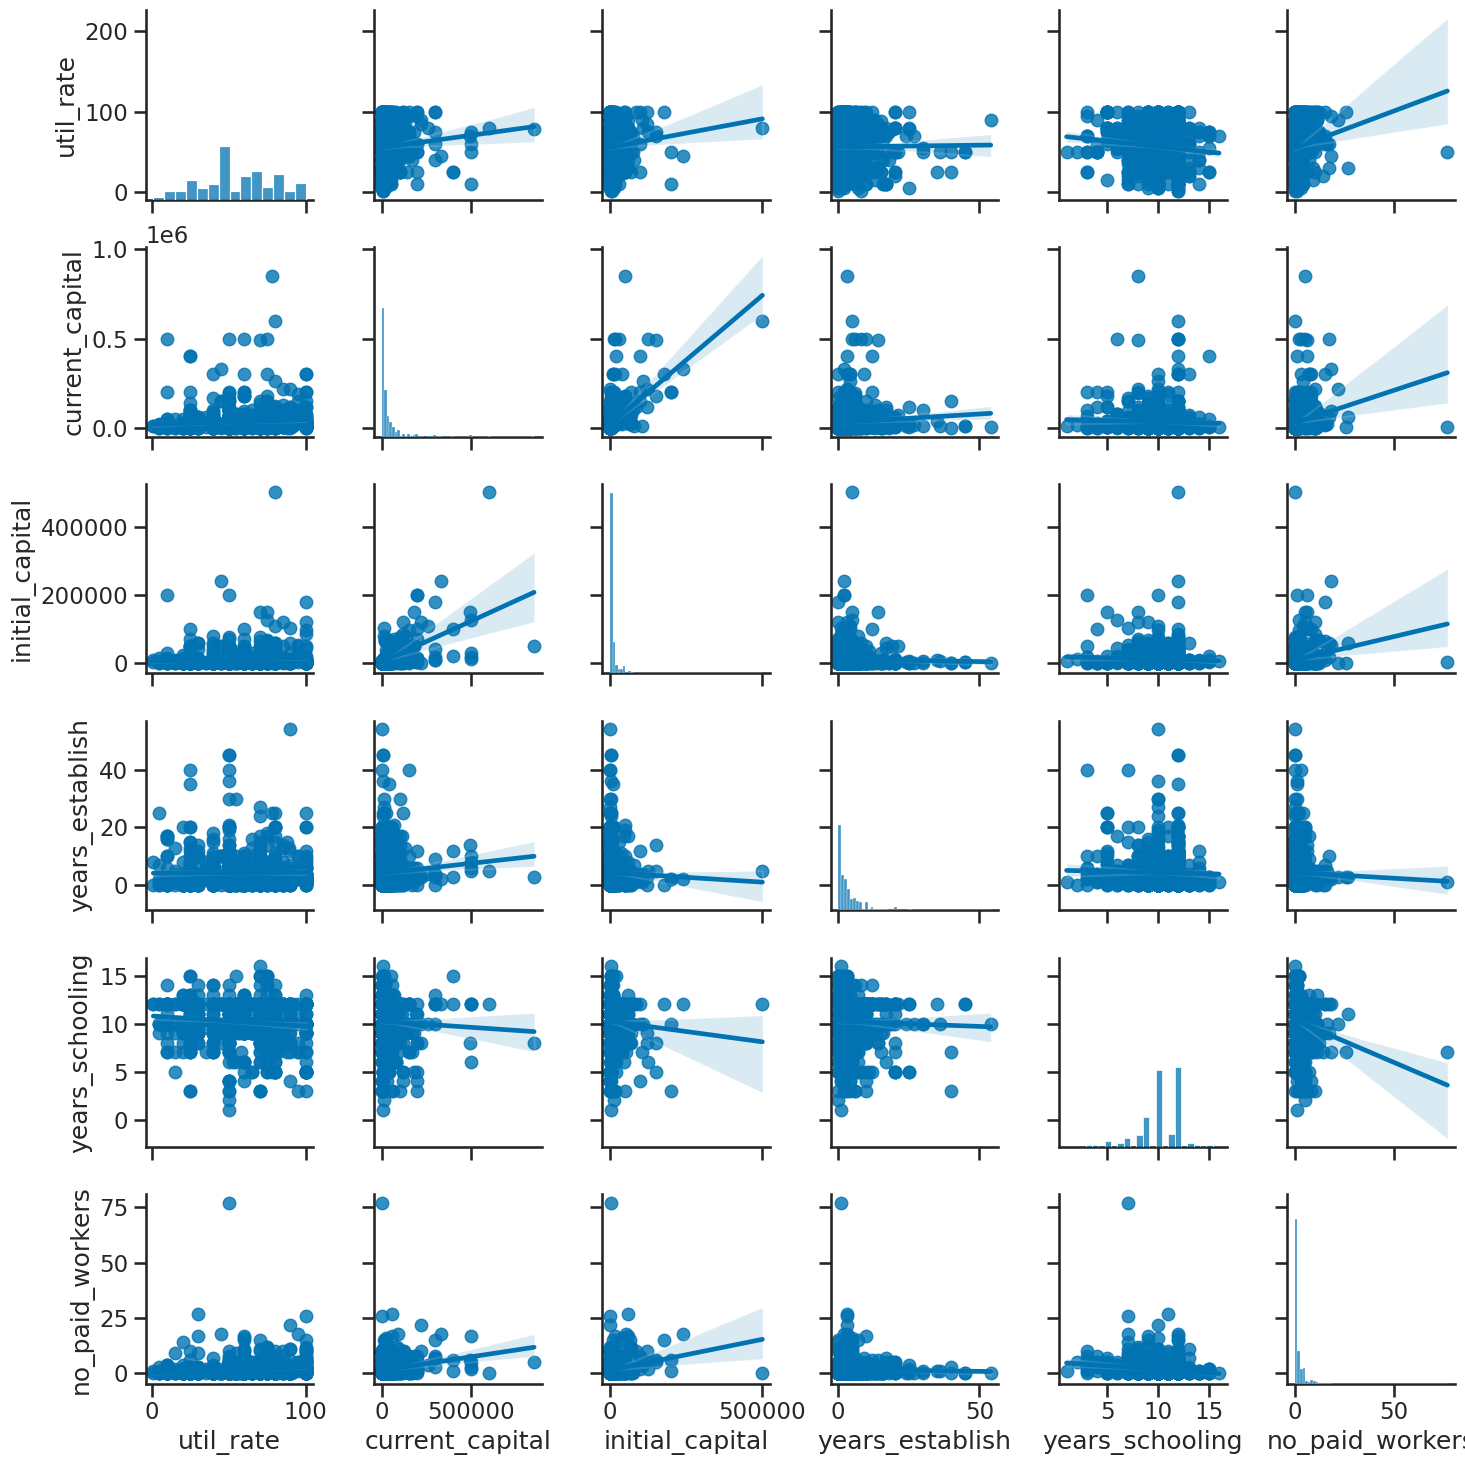

In [75]:
sns.pairplot(data = data, kind="reg")
sns.despine()
plt.show()

# current cpaital vs others

### recoding current capital

In [76]:
data["current_capital"].describe()

count       860.000000
mean      34234.709302
std       68692.331486
min         100.000000
25%        5000.000000
50%       12000.000000
75%       30000.000000
max      850000.000000
Name: current_capital, dtype: float64

In [77]:
mmin =  data.current_capital.min()
mmax = data.current_capital.max()
first_quartile = data.current_capital.quantile(0.25)
second_quartile = data.current_capital.quantile(0.5)
third_quartile = data.current_capital.quantile(0.75)
print(mmin, first_quartile, second_quartile, third_quartile, mmax)


100 5000.0 12000.0 30000.0 850000


In [78]:
# splitting current capital
data["current_capital_categorical"] = pd.cut(data["current_capital"], bins=[mmin-1, first_quartile, second_quartile, third_quartile, mmax+1], labels=["Low", "Low-medium", "High-medium", "High"])

In [79]:
cat_compare = data[["current_capital_categorical", "gender", "highest_education"]]
cat_compare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860 entries, 0 to 859
Data columns (total 3 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   current_capital_categorical  860 non-null    category
 1   gender                       860 non-null    category
 2   highest_education            860 non-null    category
dtypes: category(3)
memory usage: 3.1 KB


### current capital vs gender

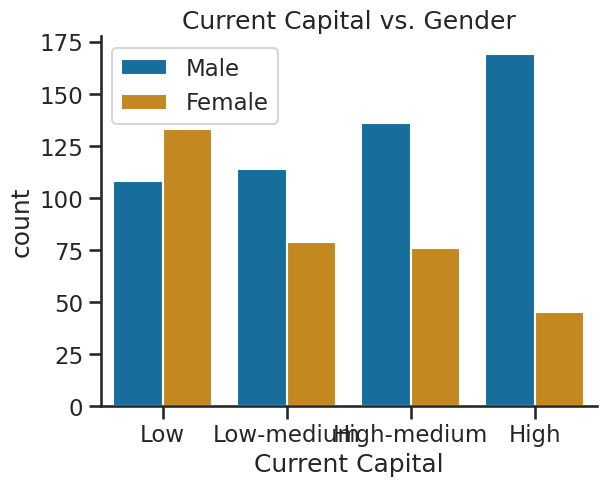

In [80]:
sns.countplot(
    data = cat_compare,
    x = "current_capital_categorical",
    hue = "gender"
)
plt.title("Current Capital vs. Gender")
plt.xlabel("Current Capital")
plt.legend(labels=["Male", "Female"])
sns.despine()
plt.show()

In [81]:
tab1 = pd.crosstab(cat_compare["current_capital_categorical"], data["gender"])

chi2, p, dof, expected1 = chi2_contingency(tab1)

print(f"Statistics: {chi2}\np-value: {p}\ndegree of freedom: {dof}\n\nobserved: \n{tab1}\n\nexpected: \n{expected1} ")

Statistics: 56.90504500890765
p-value: 2.6926638752357543e-12
degree of freedom: 3

observed: 
gender                         0    1
current_capital_categorical          
Low                          108  133
Low-medium                   114   79
High-medium                  136   76
High                         169   45

expected: 
[[147.68255814  93.31744186]
 [118.26860465  74.73139535]
 [129.91162791  82.08837209]
 [131.1372093   82.8627907 ]] 


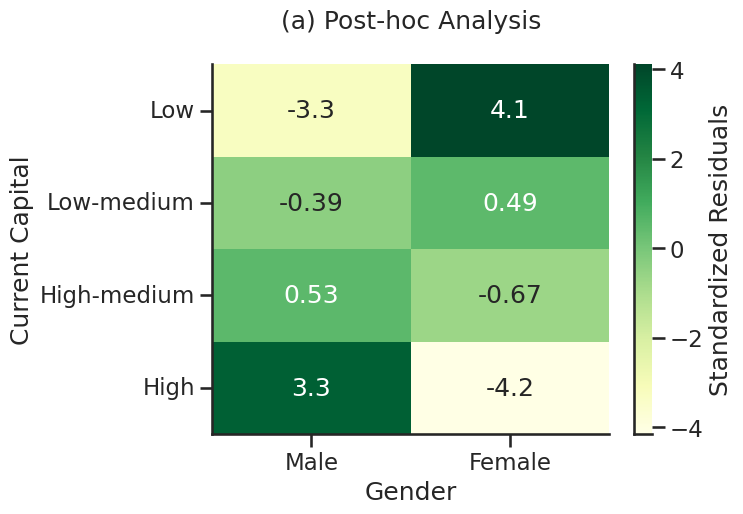

In [82]:
residuals = (tab1 - expected1)/ np.sqrt(expected1)
residuals.columns = ["Male", "Female"]

sns.heatmap(residuals, annot=True, center=0, cmap = "YlGn", cbar_kws={"label" : "Standardized Residuals"})
plt.title("(a) Post-hoc Analysis\n")
plt.xlabel("Gender")
plt.ylabel("Current Capital")
sns.despine()
plt.show()

### current capital vs highest level of education (owners)

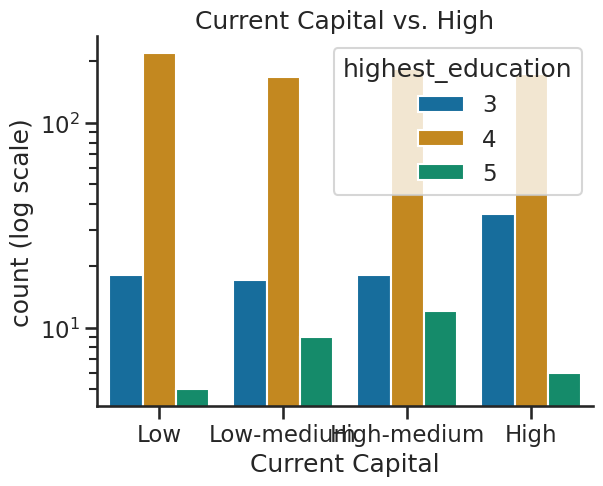

In [83]:
ax = sns.countplot(
    data = cat_compare,
    x = "current_capital_categorical",
    hue = "highest_education"
)
ax.set_yscale("log")
plt.title("Current Capital vs. High")
plt.ylabel("count (log scale)")
plt.xlabel("Current Capital")
sns.despine()
plt.show()

In [84]:
tab2 = pd.crosstab(cat_compare["current_capital_categorical"], cat_compare["highest_education"])
chi2, p, dof, expected2 = chi2_contingency(tab2)
print(f"Statistics: {chi2}\np-value: {p}\ndegree of freedom: {dof}\n\nobserved: \n{tab2}\n\nexpected: \n{expected2} ")

Statistics: 17.941791157357397
p-value: 0.006379320255157455
degree of freedom: 6

observed: 
highest_education             3    4   5
current_capital_categorical             
Low                          18  218   5
Low-medium                   17  167   9
High-medium                  18  182  12
High                         36  172   6

expected: 
[[ 24.94069767 207.09186047   8.96744186]
 [ 19.97325581 165.84534884   7.18139535]
 [ 21.93953488 182.17209302   7.88837209]
 [ 22.14651163 183.89069767   7.9627907 ]] 


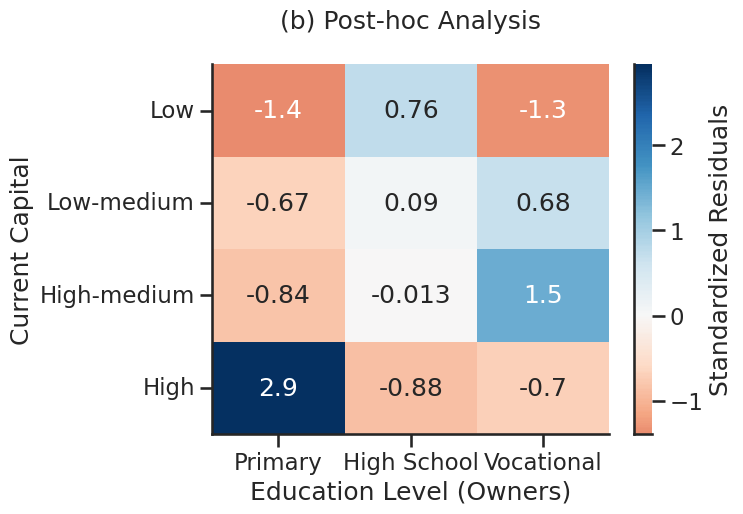

In [85]:
residuals = (tab2 - expected2)/ np.sqrt(expected2)
residuals.columns = ["Primary", "High School", "Vocational"]

sns.heatmap(residuals, annot=True, cmap="RdBu", center=0, cbar_kws = {"label" : "Standardized Residuals"})
plt.title("(b) Post-hoc Analysis\n")
plt.xlabel("Education Level (Owners)")
plt.ylabel("Current Capital")
sns.despine()
plt.show()

# Multiple Linear Regression

## Intital Full Model for checking assumptions (1st model)

### fitting full model

In [86]:
model = smf.ols(
    formula = "current_capital ~ initial_capital + years_establish + years_schooling + no_paid_workers + C(business_license) + C(loan) + C(land_premise) + C(gender)", 
    data = data,
).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        current_capital   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     66.58
Date:                Fri, 23 Jan 2026   Prob (F-statistic):           1.12e-84
Time:                        18:47:45   Log-Likelihood:                -10589.
No. Observations:                 860   AIC:                         2.120e+04
Df Residuals:                     851   BIC:                         2.124e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### Linearity Assumption

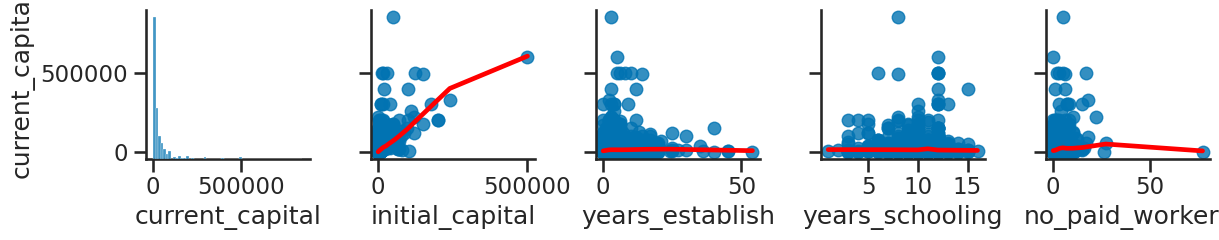

In [123]:
sns.pairplot(data = data, x_vars = ["current_capital", "initial_capital", "years_establish", "years_schooling", "no_paid_workers"],  y_vars = "current_capital", kind = "reg", plot_kws={'line_kws':{'color':'red'}, 'lowess': True})
sns.despine()
plt.show()

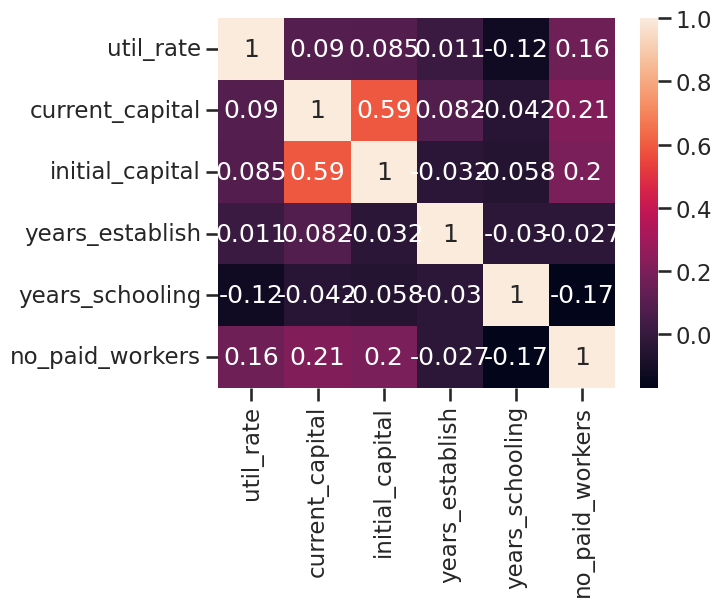

In [88]:
sns.heatmap(
    data.corr(numeric_only=True),
    annot=True
)
plt.show()

### Normality of errors assumption

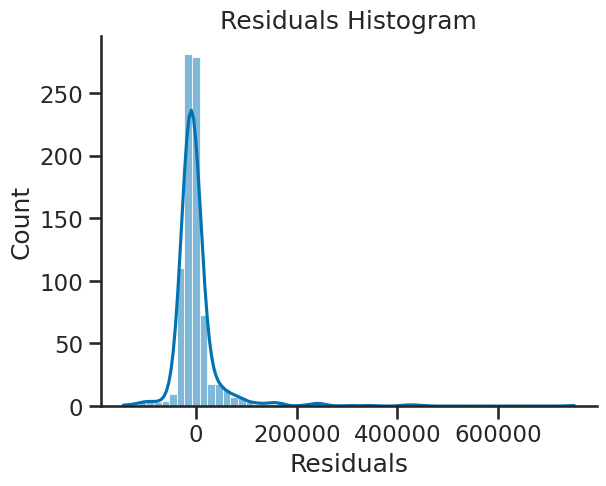

In [89]:
sns.histplot(model.resid, kde=True)
plt.title("Residuals Histogram")
plt.xlabel("Residuals")
sns.despine()
plt.show()

In [90]:
print(f"Residual skewness: {model.resid.skew()}")
print(f"Residual kurtosis: {model.resid.kurtosis()}")

Residual skewness: 6.293173537761188
Residual kurtosis: 62.821888195859046


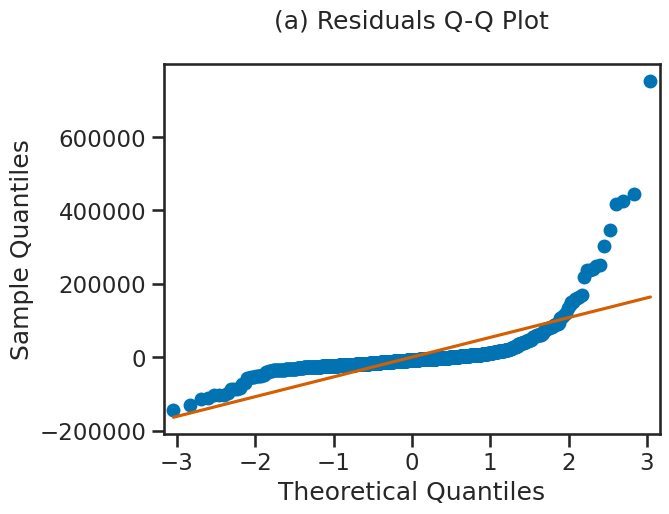

In [124]:
sm.qqplot(model.resid, line = "s")
plt.title("(a) Residuals Q-Q Plot\n")
plt.show()

In [92]:
shapiro_test = shapiro(model.resid)
print(f"Shapiro statistic: {shapiro_test.statistic}\np-value: {shapiro_test.pvalue}")

Shapiro statistic: 0.505506515007468
p-value: 1.3667390242525736e-43


### checking for constant variance (homoscedasticity)

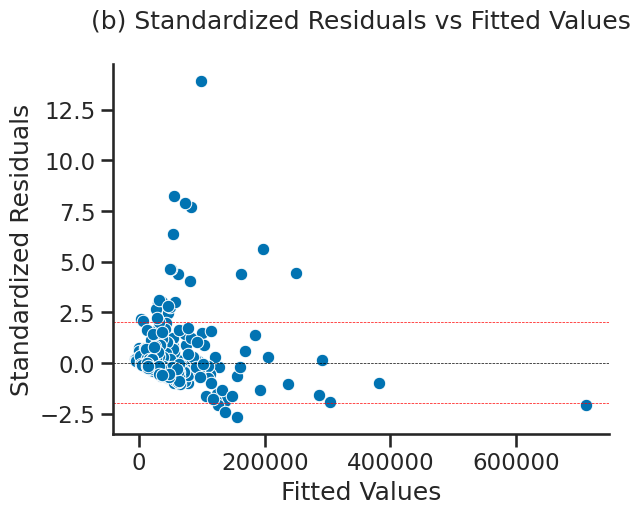

In [125]:
standard_resid = model.resid / np.sqrt(model.mse_resid)

sns.scatterplot(x = model.fittedvalues, y = standard_resid)
plt.title("(b) Standardized Residuals vs Fitted Values\n")
plt.ylabel("Standardized Residuals")
plt.xlabel("Fitted Values")
sns.despine()
plt.axhline(0, color = "black", linestyle = "--", linewidth = 0.5)
plt.axhline(2, color = "red", linestyle = "--", linewidth = 0.5)
plt.axhline(-2, color = "red", linestyle = "--", linewidth = 0.5)

plt.show()

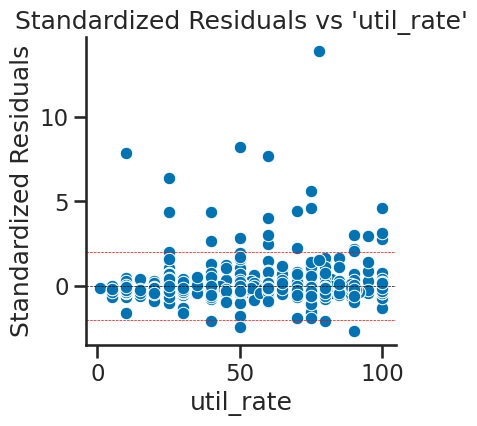

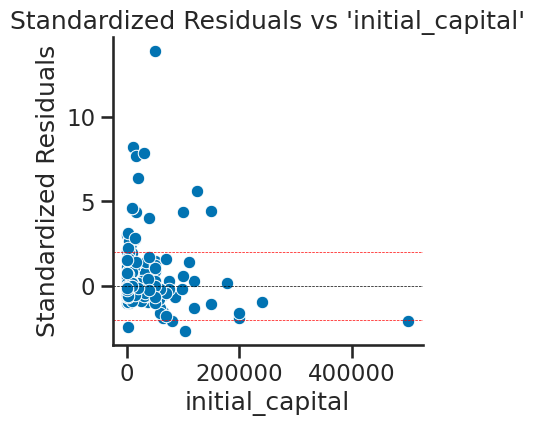

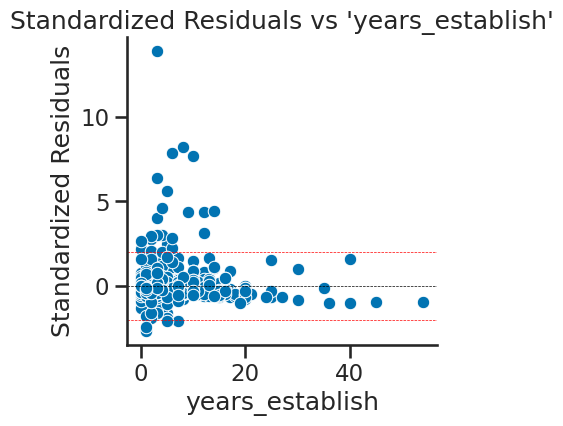

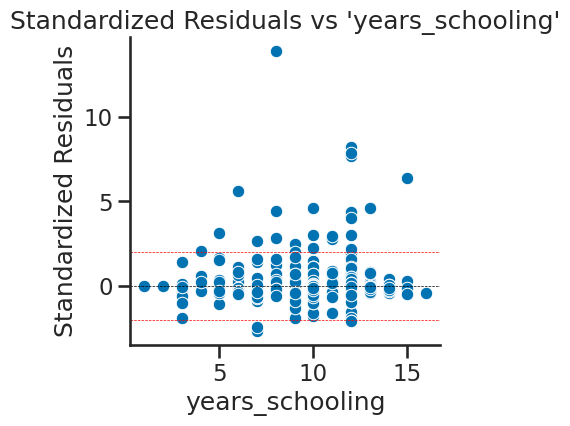

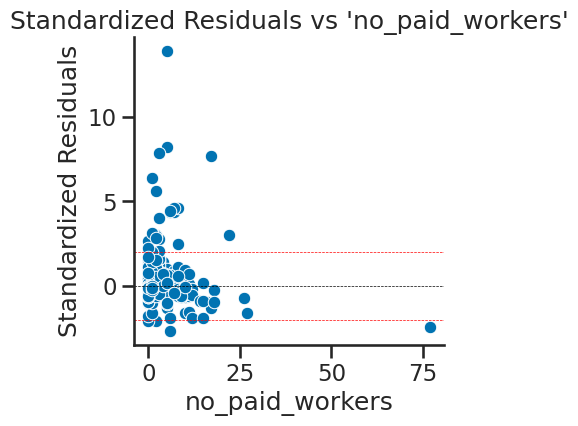

In [94]:
quant_cols = ["util_rate", "initial_capital", "years_establish", "years_schooling", "no_paid_workers"]
for col in quant_cols:
    plt.subplots(figsize = (4,4))
    sns.scatterplot(x = data[col], y = standard_resid)
    plt.title(f"Standardized Residuals vs '{col}'")
    plt.ylabel("Standardized Residuals")
    plt.xlabel(col)
    sns.despine()

    plt.axhline(0, color = "black", linestyle = "--", linewidth = 0.5)
    plt.axhline(2, color = "red", linestyle = "--", linewidth = 0.5)
    plt.axhline(-2, color = "red", linestyle = "--", linewidth = 0.5)
    plt.show()

Breusch-Pagan test is invalid since the erros are not normally distributed

We have explored it anyways

In [95]:
bp_data = data.drop(columns="current_capital").copy()
bp_data["Z"] = (model.resid ** 2) / model.mse_resid

bp = smf.ols(
    formula = "Z ~ initial_capital + years_establish + years_schooling + no_paid_workers + util_rate + C(business_registered) + C(TIN) + C(business_license) + C(MSE_type) + C(loan) + C(land_premise) + C(one_stop_service) + C(gender) + C(highest_education) + C(subsector)",
    data = bp_data
    ).fit()
anova_table = sm.stats.anova_lm(bp, typ=1)
print(anova_table)

                           df        sum_sq     mean_sq          F    PR(>F)
C(business_registered)    1.0     67.376280   67.376280   1.115277  0.291242
C(TIN)                    1.0    555.976295  555.976295   9.203053  0.002491
C(business_license)       1.0    381.908551  381.908551   6.321717  0.012113
C(MSE_type)               1.0    702.107477  702.107477  11.621957  0.000683
C(loan)                   1.0     61.153580   61.153580   1.012273  0.314650
C(land_premise)           1.0     11.919915   11.919915   0.197310  0.657016
C(one_stop_service)       1.0     17.884920   17.884920   0.296048  0.586515
C(gender)                 1.0    211.935795  211.935795   3.508165  0.061415
C(highest_education)      2.0    546.845867  273.422934   4.525959  0.011091
C(subsector)              7.0    435.612450   62.230350   1.030096  0.408236
initial_capital           1.0    286.494666  286.494666   4.742335  0.029708
years_establish           1.0     16.310079   16.310079   0.269980  0.603483

In [96]:
ssr_total = anova_table["sum_sq"].iloc[:-1].sum()
ssr_total / 2

np.float64(1854.1106941824173)

In [97]:
critical_value = stats.chi2.ppf(0.95, df=22)
print(f"Chi-square Critical Value: {critical_value:.4f}")

Chi-square Critical Value: 33.9244


"Koenker-Bassett" Modification (Studentized BP Test) that doesn't require the assumption of normality of residuals

In [98]:
bp_test = dg.het_breuschpagan(model.resid, model.model.exog)
labels = ['Lagrange Multiplier statistic', 'p-value', 'f-value', 'f p-value']
results = dict(zip(labels, bp_test))
for key, value in results.items():
    print(f"{key}: {value:.4f}")

Lagrange Multiplier statistic: 27.6864
p-value: 0.0005
f-value: 3.5385
f p-value: 0.0005


### Chekcing for autocorrelation

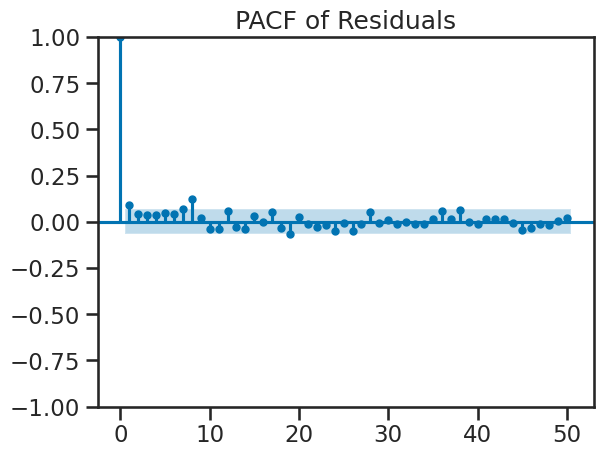

In [99]:
plot_pacf(model.resid, lags = 50, title = "PACF of Residuals")
plt.show()

Durbin watson test

In [100]:
dw = durbin_watson(model.resid) 

print(f"DW: {dw}")

DW: 1.820738953540482


Bruesch godfery test

In [101]:
bg_test = dg.acorr_breusch_godfrey(model, nlags=5)

results = dict(zip(["LM-Statistic", "LM-p-value", "F-Statstic", "F-p-value"], bg_test))
for key, value in results.items():
    print(f"{key}: {value:.4f}")

LM-Statistic: 13.3673
LM-p-value: 0.0202
F-Statstic: 2.6715
F-p-value: 0.0209


### checking for multicollinearity

we have already seen a correlation heatmap, we will start with VIF and follow with calculation the condition number

In [102]:
X = model.model.exog

vif_df = pd.DataFrame()
vif_df["predictors"] = model.model.exog_names
vif_df["VIF"] = [variance_inflation_factor(X, i) for i in range(vif_df.shape[0])]

vif_df.sort_values("VIF", ascending=False)

,predictors,VIF
0,Intercept,31.318362
8,no_paid_workers,1.137710
3,C(land_premise)[T.1],1.129244
4,C(gender)[T.1],1.061632
2,C(loan)[T.1],1.059312
7,years_schooling,1.051546
5,initial_capital,1.045782
6,years_establish,1.038753
1,C(business_license)[T.1],1.035689


In [103]:
eigenvals = np.linalg.eigvals(np.dot(X.T, X))
condition_index = np.sqrt(max(eigenvals) / min(eigenvals))
print(f"Codintion Index: {condition_index}")

Codintion Index: 171633.15699936857


- **Differences in Scale**: If one variable is in the thousands (like Area in sq meters) and another is a dummy (0 or 1), the eigenvalues of the matrix will be vastly different, causing the Condition Number to explode even if the variables aren't actually correlated.

- **The Intercept**: The Intercept often has a high VIF because the constant column (all 1s) can be partially "explained" by the other predictors if they don't have a mean of zero.

## Transforming the dependent and some independent variables (2nd model)

### Transformations and their effects

In [104]:
data["current_capital_log"] = np.log1p(data["current_capital"])
data["initial_capital_log"] = np.log1p(data["initial_capital"])
data["years_establish_log"] = np.log1p(data["years_establish"])
data["no_paid_workers_log"] = np.log1p(data["no_paid_workers"])
data["years_schooling_sq"] = data["years_schooling"] ** 2

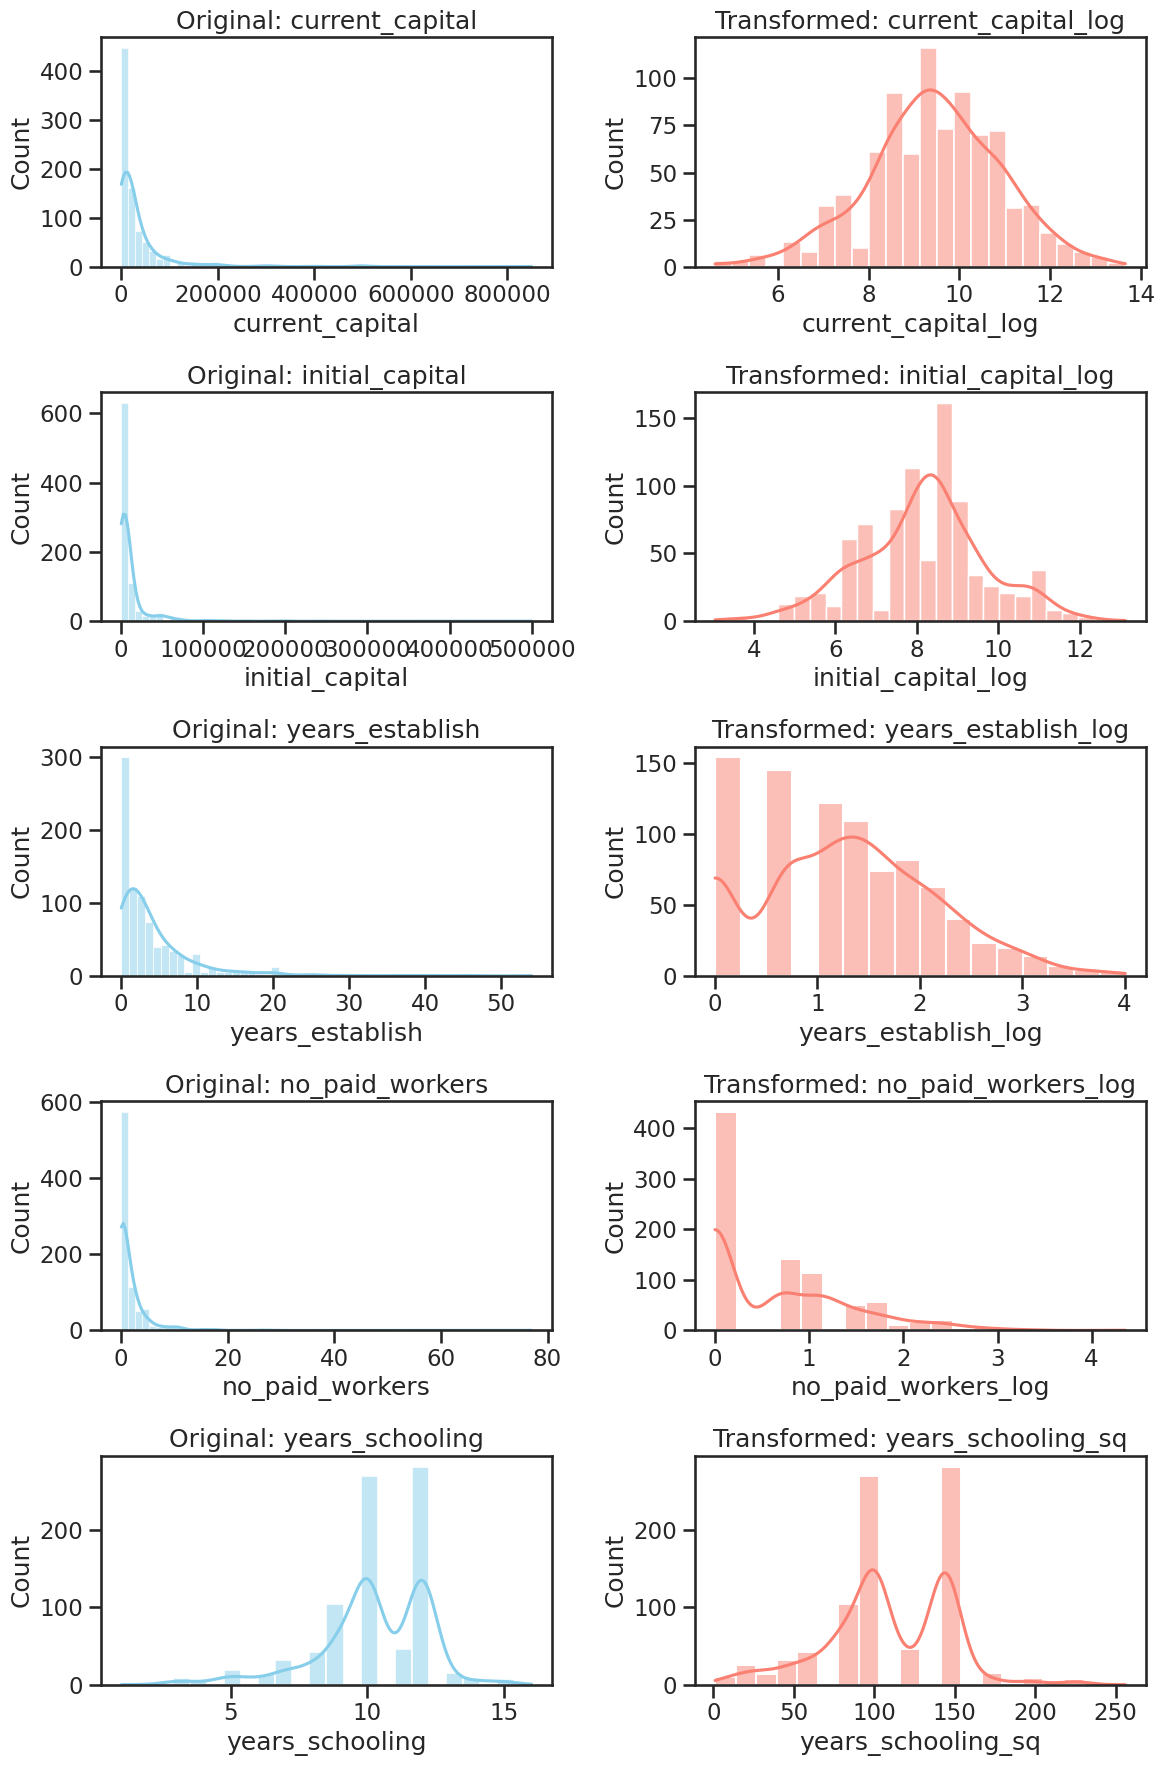

In [105]:
vars_to_plot = [
    ('current_capital', 'current_capital_log'),
    ('initial_capital', 'initial_capital_log'),
    ('years_establish', 'years_establish_log'),
    ('no_paid_workers', 'no_paid_workers_log'),
    ('years_schooling', 'years_schooling_sq')
]

fig, axes = plt.subplots(len(vars_to_plot), 2, figsize=(12, 18))

for i, (orig, trans) in enumerate(vars_to_plot):
    # Before transformation
    sns.histplot(data[orig], kde=True, ax=axes[i, 0], color='skyblue')
    axes[i, 0].set_title(f'Original: {orig}')
    
    # After transformation
    sns.histplot(data[trans], kde=True, ax=axes[i, 1], color='salmon')
    axes[i, 1].set_title(f'Transformed: {trans}')

plt.tight_layout()

### Fiting OLS and Checking assumptions

#### Fitting OLS

In [106]:
model_log = smf.ols(
    formula = "I(np.log1p(current_capital)) ~ I(np.log1p(initial_capital)) + I(np.log1p(years_establish)) + I(years_schooling ** 2) + I(np.log1p(no_paid_workers)) +  C(gender) + C(business_license) + C(loan) +C(land_premise)", 
    data = data,
).fit()


In [107]:
print(model_log.summary())

                                 OLS Regression Results                                 
Dep. Variable:     I(np.log1p(current_capital))   R-squared:                       0.596
Model:                                      OLS   Adj. R-squared:                  0.592
Method:                           Least Squares   F-statistic:                     157.0
Date:                          Fri, 23 Jan 2026   Prob (F-statistic):          8.28e-162
Time:                                  18:47:54   Log-Likelihood:                -1159.3
No. Observations:                           860   AIC:                             2337.
Df Residuals:                               851   BIC:                             2379.
Df Model:                                     8                                         
Covariance Type:                      nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------

#### Linearity

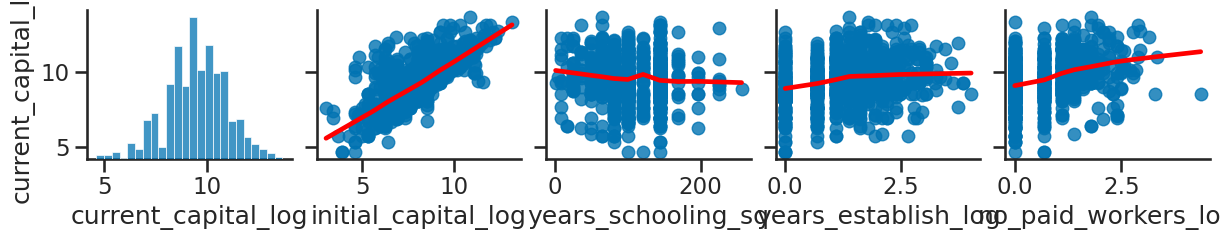

In [108]:
sns.pairplot(data = data, y_vars = "current_capital_log", x_vars = ["current_capital_log", "initial_capital_log", "years_schooling_sq", "years_establish_log", "no_paid_workers_log"], kind = "reg", plot_kws={'line_kws':{'color':'red'}, 'lowess': True})
sns.despine()
plt.show()

#### normaility of errors

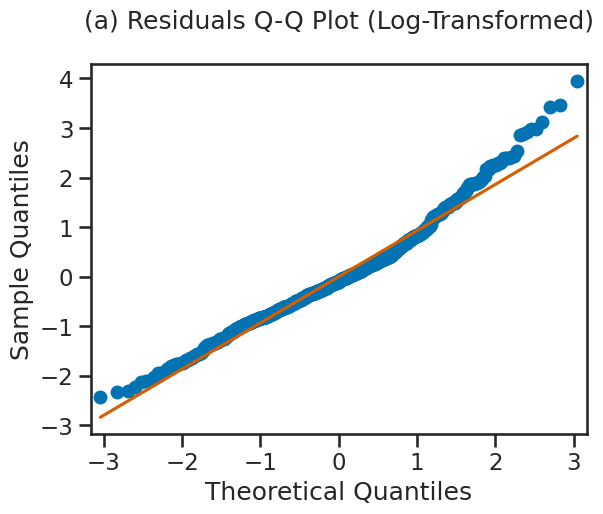

In [128]:
sm.qqplot(model_log.resid, line = "s")
plt.title("(a) Residuals Q-Q Plot (Log-Transformed)\n")
plt.show()

#### cosntant variance

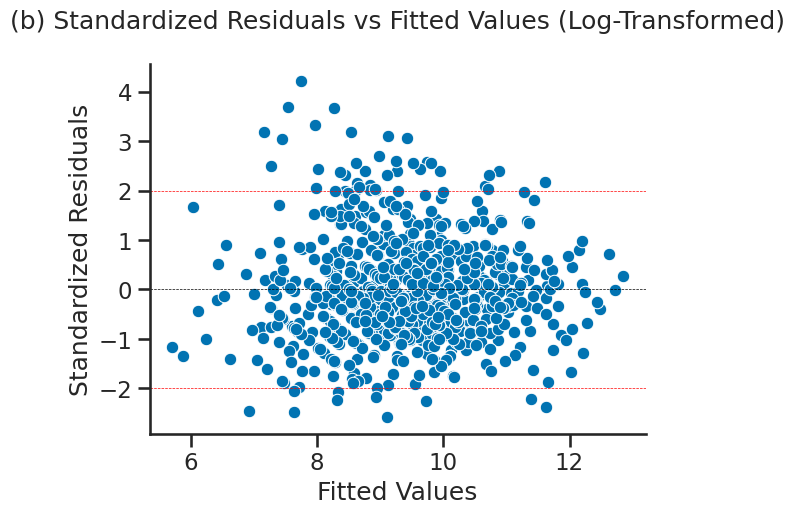

In [129]:
standard_resid = model_log.resid / np.sqrt(model_log.mse_resid)

sns.scatterplot(x = model_log.fittedvalues, y = standard_resid)
plt.title("(b) Standardized Residuals vs Fitted Values (Log-Transformed)\n")
plt.ylabel("Standardized Residuals")
plt.xlabel("Fitted Values")
sns.despine()
plt.axhline(0, color = "black", linestyle = "--", linewidth = 0.5)
plt.axhline(2, color = "red", linestyle = "--", linewidth = 0.5)
plt.axhline(-2, color = "red", linestyle = "--", linewidth = 0.5)

plt.show()

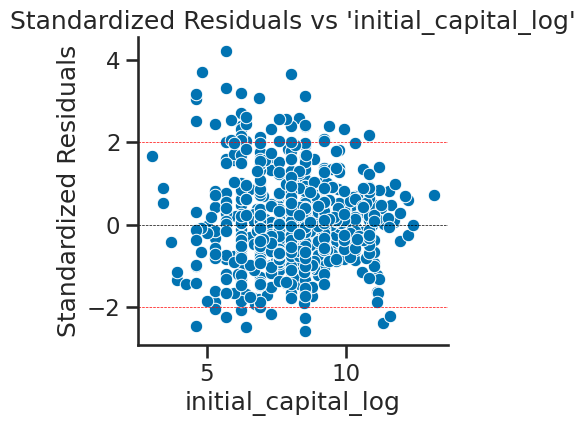

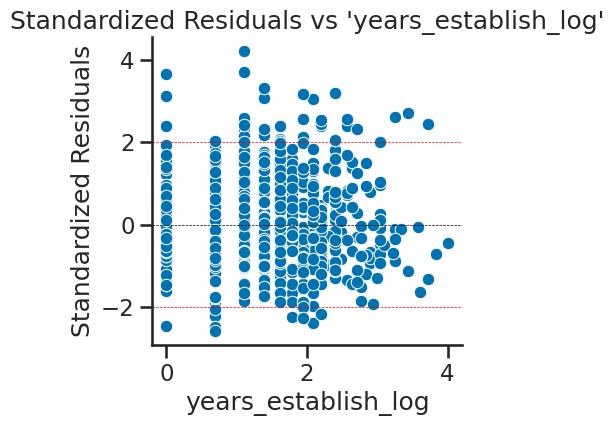

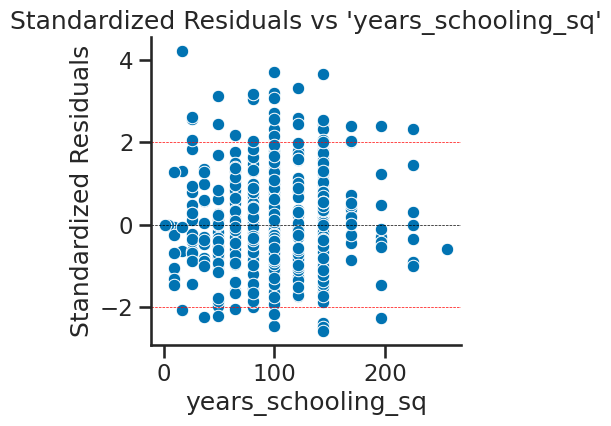

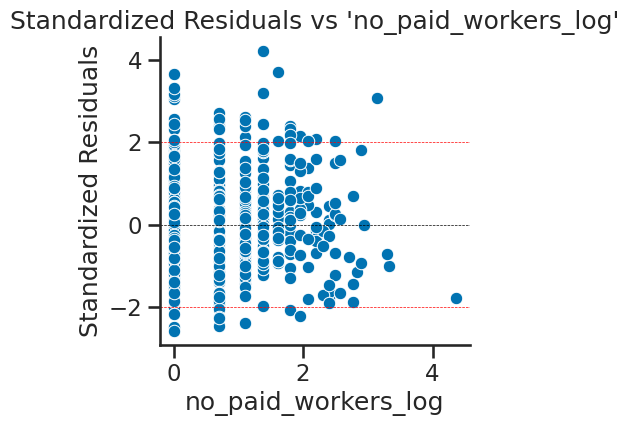

In [110]:
quant_cols = [ "initial_capital_log", "years_establish_log", "years_schooling_sq", "no_paid_workers_log"]
for col in quant_cols:
    plt.subplots(figsize = (4,4))
    sns.scatterplot(x = data[col], y = standard_resid)
    plt.title(f"Standardized Residuals vs '{col}'")
    plt.ylabel("Standardized Residuals")
    plt.xlabel(col)
    sns.despine()

    plt.axhline(0, color = "black", linestyle = "--", linewidth = 0.5)
    plt.axhline(2, color = "red", linestyle = "--", linewidth = 0.5)
    plt.axhline(-2, color = "red", linestyle = "--", linewidth = 0.5)
    plt.show()

In [130]:
bp_test = dg.het_breuschpagan(model_log.resid, model_log.model.exog)
labels = ['Lagrange Multiplier statistic', 'p-value', 'f-value', 'f p-value']
results = dict(zip(labels, bp_test))
for key, value in results.items():
    print(f"{key}: {value:.4f}")

Lagrange Multiplier statistic: 99.1717
p-value: 0.0000
f-value: 13.8657
f p-value: 0.0000


#### autocorrelation check

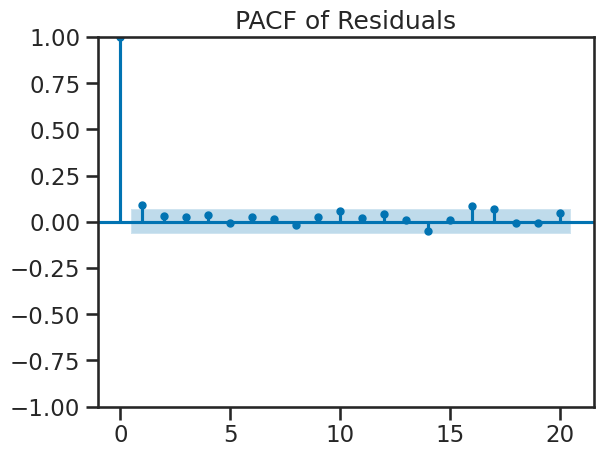

In [111]:
plot_pacf(model_log.resid, lags = 20, title = "PACF of Residuals")
plt.show()

In [112]:
dw_statistic = durbin_watson(model_log.wresid)

print(f"Durbin-Watson statistic: {dw_statistic}")

Durbin-Watson statistic: 1.8201315184193003


#### multicollinearity

In [113]:
X = model_log.model.exog

vif_df = pd.DataFrame()
vif_df["predictors"] = model_log.model.exog_names
vif_df["VIF"] = [variance_inflation_factor(X, i) for i in range(vif_df.shape[0])]

vif_df.sort_values("VIF", ascending=False)

,predictors,VIF
0,Intercept,42.420175
8,I(np.log1p(no_paid_workers)),1.229635
4,C(land_premise)[T.1],1.133104
5,I(np.log1p(initial_capital)),1.126048
1,C(gender)[T.1],1.103330
2,C(business_license)[T.1],1.097113
6,I(np.log1p(years_establish)),1.082617
3,C(loan)[T.1],1.064967
7,I(years_schooling ** 2),1.061111


## Weighted Least Squares for hetroscedasticity (3rd model)

#### WLS weights and fitting

In [114]:
ols_model = smf.ols(
    formula = "I(np.log1p(current_capital)) ~ I(np.log1p(initial_capital)) + I(np.log1p(years_establish)) + I(years_schooling ** 2) + I(np.log1p(no_paid_workers)) +  C(gender) + C(business_license) + C(loan) +C(land_premise) + C(subsector) + C(subsector)", 
    data = data,
).fit()

sq_resid = (ols_model.resid) ** 2
variance_data = data.copy()
variance_data["sq_resid"] = sq_resid

predictor_vars = "I(np.log1p(initial_capital)) + I(np.log1p(years_establish)) + I(years_schooling ** 2) + I(np.log1p(no_paid_workers)) +  C(gender) + C(business_license) + C(loan) +C(land_premise) + C(subsector) + C(subsector)"

sq_resid_model = smf.ols(
    formula = f"sq_resid ~ {predictor_vars}",
    data = variance_data
).fit()

weights = 1 / (np.maximum(sq_resid_model.fittedvalues, 1e-6))

In [133]:
model_wls = smf.wls(
    formula = "I(np.log1p(current_capital)) ~ I(np.log1p(initial_capital)) + I(np.log1p(years_establish)) + I(years_schooling ** 2) + I(np.log1p(no_paid_workers)) +  C(gender) + C(business_license) + C(loan) +C(land_premise)",
    data = data,
    weights = weights
).fit()

In [134]:
print(model_wls.summary())

                                 WLS Regression Results                                 
Dep. Variable:     I(np.log1p(current_capital))   R-squared:                       0.816
Model:                                      WLS   Adj. R-squared:                  0.814
Method:                           Least Squares   F-statistic:                     472.2
Date:                          Fri, 23 Jan 2026   Prob (F-statistic):          7.69e-307
Time:                                  20:02:24   Log-Likelihood:                -4590.2
No. Observations:                           860   AIC:                             9198.
Df Residuals:                               851   BIC:                             9241.
Df Model:                                     8                                         
Covariance Type:                      nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------

### Checking assumptions

#### Homoscedasticity

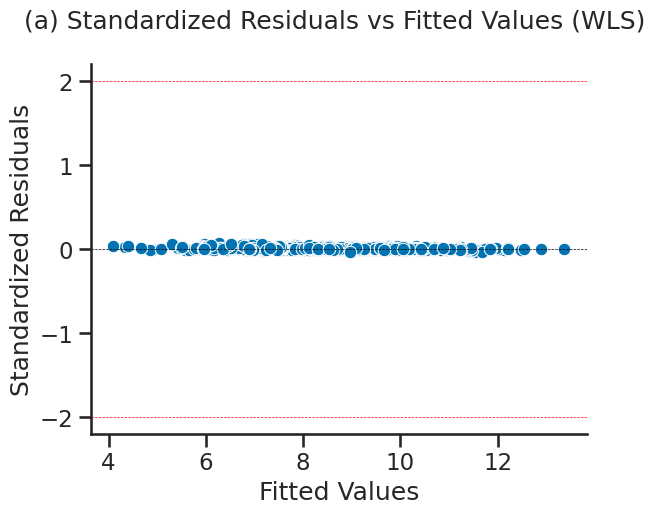

In [135]:
standard_resid = model_wls.resid / np.sqrt(model_wls.mse_resid)

sns.scatterplot(x = model_wls.fittedvalues, y = standard_resid)
plt.title("(a) Standardized Residuals vs Fitted Values (WLS) \n")
plt.ylabel("Standardized Residuals")
plt.xlabel("Fitted Values")
sns.despine()
plt.axhline(0, color = "black", linestyle = "--", linewidth = 0.5)
plt.axhline(2, color = "red", linestyle = "--", linewidth = 0.5)
plt.axhline(-2, color = "red", linestyle = "--", linewidth = 0.5)

plt.show()

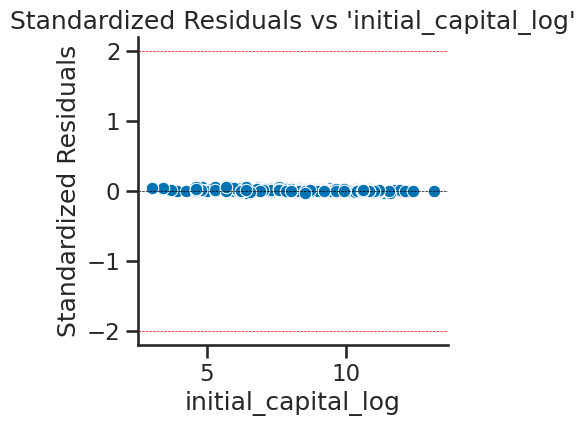

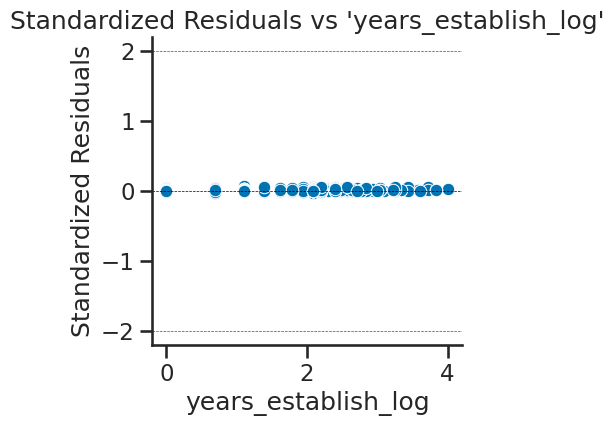

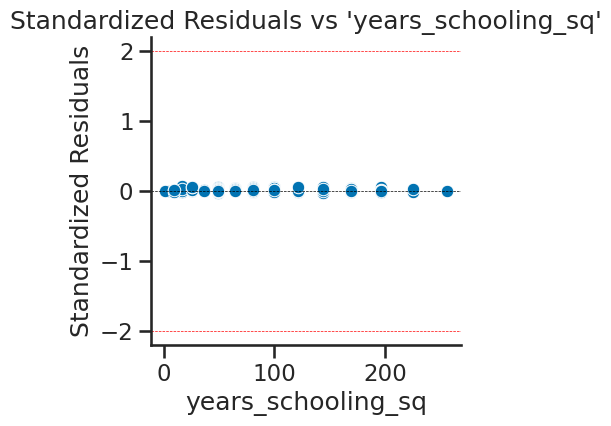

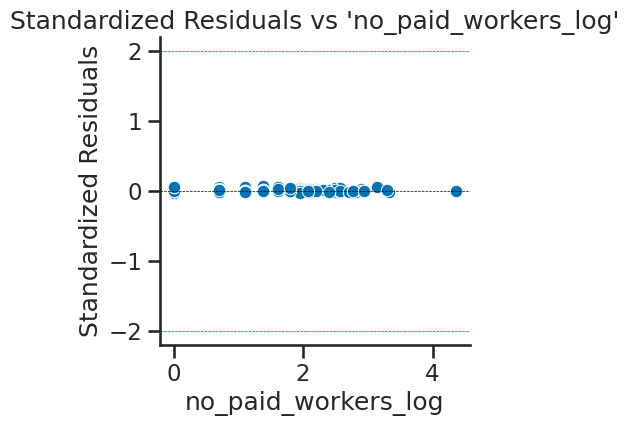

In [118]:
quant_cols = [ "initial_capital_log", "years_establish_log", "years_schooling_sq", "no_paid_workers_log"]
for col in quant_cols:
    plt.subplots(figsize = (4,4))
    sns.scatterplot(x = data[col], y = standard_resid)
    plt.title(f"Standardized Residuals vs '{col}'")
    plt.ylabel("Standardized Residuals")
    plt.xlabel(col)
    sns.despine()

    plt.axhline(0, color = "black", linestyle = "--", linewidth = 0.5)
    plt.axhline(2, color = "red", linestyle = "--", linewidth = 0.5)
    plt.axhline(-2, color = "red", linestyle = "--", linewidth = 0.5)
    plt.show()

#### autocorrelation check

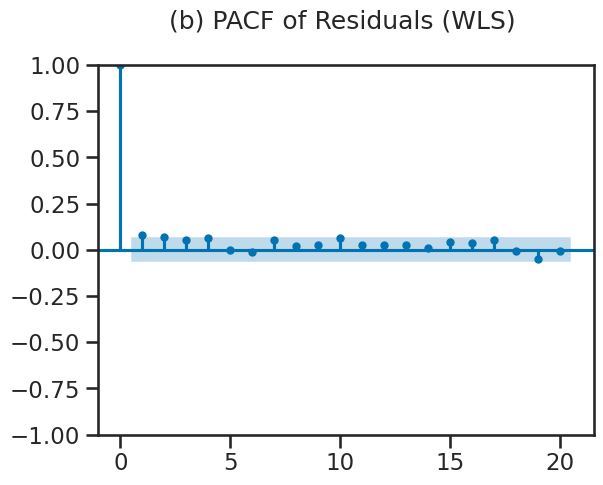

In [137]:
plot_pacf(model_wls.resid, lags = 20, title = "(b) PACF of Residuals (WLS) \n")
plt.show()

In [120]:
dw_statistic = durbin_watson(model_wls.wresid)

print(f"Durbin-Watson statistic: {dw_statistic}")

Durbin-Watson statistic: 1.9663360022304515


#### multicollinearity

In [121]:
X = model_wls.model.exog

vif_df = pd.DataFrame()
vif_df["predictors"] = model_wls.model.exog_names
vif_df["VIF"] = [variance_inflation_factor(X, i) for i in range(vif_df.shape[0])]

vif_df.sort_values("VIF", ascending=False)

,predictors,VIF
0,Intercept,42.420175
8,I(np.log1p(no_paid_workers)),1.229635
4,C(land_premise)[T.1],1.133104
5,I(np.log1p(initial_capital)),1.126048
1,C(gender)[T.1],1.103330
2,C(business_license)[T.1],1.097113
6,I(np.log1p(years_establish)),1.082617
3,C(loan)[T.1],1.064967
7,I(years_schooling ** 2),1.061111
